# This file is used in the demo


In [ ]:
# Import libraries
import os, sys, platform
# import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import librosa as lbr
# !pip install pydub
from pydub import AudioSegment, silence
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Audio
# from google.colab import drive

In [ ]:
# drive.mount('/content/drive')

def linux_distribution():
    try:
        return platform.linux_distribution()
    except:
        return 'N/A'

print('''Python version: %s
platform: %s
uname: %s
version: %s
''' % (sys.version.split('\n'), platform.platform(), platform.uname(), platform.version()))

# tf.test.gpu_device_name()
# !/opt/bin/nvidia-smi

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.chdir('/content/drive/Shareddrives/Part IV 700 - Siwei Yang and Sky Nguyen/Colab/')
# print('Current Working Directory ' , os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python version: ['3.7.12 (default, Sep 10 2021, 00:21:48) ', '[GCC 7.5.0]']
platform: Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
uname: uname_result(system='Linux', node='cccd2eefde39', release='5.4.104+', version='#1 SMP Sat Jun 5 09:50:34 PDT 2021', machine='x86_64', processor='x86_64')
version: #1 SMP Sat Jun 5 09:50:34 PDT 2021

/bin/bash: /opt/bin/nvidia-smi: No such file or directory
Current Working Directory  /content/drive/Shareddrives/Part IV 700 - Siwei Yang and Sky Nguyen/Colab


The input of the script

In [ ]:
audioInputFolder = 'demo/audioInput/'
for dir, _, filenames in os.walk(audioInputFolder):
    pass

In [ ]:
audioInput = audioInputFolder+random.choice(filenames)
# audioInput = 'demo/JLCO_male2_confident_13a_1.wav'
Audio(audioInput)

## Preprocessing & Fearure Extraction


In [ ]:
def silenceStampExtract(audioPath, length):
    myaudio = AudioSegment.from_wav(audioPath)
    slc = silence.detect_silence(myaudio, min_silence_len=1000, silence_thresh=-32)
    slc = [((start/1000),(stop/1000)) for start,stop in slc] # convert to sec
    slc = np.array([item for sublist in slc for item in sublist]) # flatten
    slc = np.around(slc, 2) # keep 2 dp
    slc = (slc*100-slc*100%4)/100 # evaluate points to nearest previous 40ms stamp
    # Tag filling
    tagList = list()
    slc = np.append(slc, 9999) # use length to determine the end
    time = 0.00
    idx = 0
    if slc[0] == 0:
        # filling start with Stag = 'S'
        tag = 'S'
        idx += 1
    else:
        # filling start with Stag = 'V'
        tag = 'V'
    for i in range(length):
        if time >= slc[idx]:
            idx += 1
            tag = 'V' if (idx % 2 == 0) else 'S'
        else:
            pass
        tagList.append(tag)
        time += 0.02
    return pd.DataFrame(tagList, columns=['voiceTag'])

In [ ]:
def featureExtract(audioFile):
    # parameters of 20ms window under 44.1kHZ
    # samplingRate = 44100
    # frameLength = 882
    frameLengthT = 0.02 # 20ms
    mfccNum = 5

    x, sr = lbr.load(audioFile, sr=None, mono=True)
    frameLength = int(sr*frameLengthT)
    frames = range(len(x)//frameLength+1)
    t = lbr.frames_to_time(frames, sr=sr, hop_length=frameLength)

    ##################Energy##################
    rms = ((lbr.feature.rms(x, frame_length=frameLength, hop_length=frameLength, center=True))[0])
    rms = 20*np.log10(rms)

    ##################F0##################
    f0Result = lbr.yin(x, 50, 300, sr, frame_length=frameLength*4)

    ##################MFCC##################
    # Transpose mfccResult matrix
    mfccResult = lbr.feature.mfcc(x, sr=sr, n_mfcc=mfccNum, hop_length=frameLength).T

    ########################################
    dfT = pd.DataFrame(t, columns=['Time'])
    dfR = pd.DataFrame(rms, columns=['RMS'])
    dfF = pd.DataFrame(f0Result, columns=['F0'])
    
    # MFCC Title
    mfccTitle = list()
    for num in range(mfccNum):
        mfccTitle.append('MFCC'+str(num+1))
    dfM = pd.DataFrame(mfccResult, columns=mfccTitle)

    return dfT.join(dfR).join(dfF).join(dfM)

In [ ]:
currentDf = featureExtract(audioInput)
tagDf = silenceStampExtract(audioInput, currentDf.shape[0])
currentDf = currentDf.join(tagDf)

In [ ]:
currentDf

,Time,RMS,F0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,voiceTag
0,0.00,-72.097923,56.358144,-700.619873,49.450111,22.186386,11.484383,14.144665,V
1,0.02,-71.999725,55.966622,-698.202332,49.745644,21.623264,15.863258,22.189541,V
2,0.04,-69.460686,58.477131,-691.756226,52.324650,12.954571,5.476787,15.694820,V
3,0.06,-69.601334,54.158325,-685.742920,63.439499,24.624187,11.036320,15.895718,V
4,0.08,-74.659172,121.189942,-702.984009,47.557167,24.104359,15.921921,15.731060,V
...,...,...,...,...,...,...,...,...,...
58,1.16,-67.057877,65.423171,-707.340820,46.132912,30.684265,21.449688,13.879394,S
59,1.18,-70.376038,57.956232,-714.533020,38.207451,27.816959,24.453209,19.841633,S
60,1.20,-71.432724,117.041315,-716.612488,38.301086,31.338467,25.811808,18.332623,S
61,1.22,-70.666946,102.301411,-723.159424,30.729145,27.289646,26.601044,23.492273,S


## Machine Learning

In [ ]:
# prepare data for lstms
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define scaler, feature number and number of step looking back
scale_range = (0, 1)
scaler = MinMaxScaler(feature_range=scale_range)
n_steps = 24  # exclude the current step
n_features = 7

transformTarget = True

In [ ]:
testingDataset = currentDf

In [ ]:
testingDataset = testingDataset[['RMS', 'F0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5']]

# load and build testing dataset
values = testingDataset.values
# normalize features
testingScaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(testingScaled, n_steps, 1)
print(reframed.shape)
values = reframed.values
test = values
test_X = test
# reshape input to be 3D [samples, timesteps (n_steps before + 1 current step), features]
test_X = test_X.reshape((test_X.shape[0], n_steps + 1, n_features))

(39, 175)


In [ ]:
arousalModelPath = 'demo/modelA0921' # 'demo/mArousal.hdf5'
valenceModelPath = 'demo/modelV1012' # 'demo/mValence.hdf5'

In [ ]:
arousalModel = keras.models.load_model(arousalModelPath)
valenceModel = keras.models.load_model(valenceModelPath)

In [ ]:
# construct scaler for target
if transformTarget:
    # fit inverse scaler
    trainTarget = (pd.read_csv('demo/allFileCombineU.csv'))['Arousal'][n_steps:]
    scaler.fit_transform(np.array(trainTarget).reshape(-1, 1))

### Arousal


In [ ]:
# make a prediction
if transformTarget:
    inv_yPredict = arousalModel.predict(test_X)
    # inv transform the predicted value
    yPredict = scaler.inverse_transform(inv_yPredict.reshape(-1, 1))
    yPredict = yPredict[:, 0]
else:
    yPredict = arousalModel.predict(test_X)

a_pred_test_list = [i for i in yPredict]

### Valence


In [ ]:
# make a prediction
if transformTarget:
    inv_yPredict = valenceModel.predict(test_X)
    # inv transform the predicted value
    yPredict = scaler.inverse_transform(inv_yPredict.reshape(-1, 1))
    yPredict = yPredict[:, 0]
else:
    yPredict = valenceModel.predict(test_X)

v_pred_test_list = [i for i in yPredict]

## Result Plots



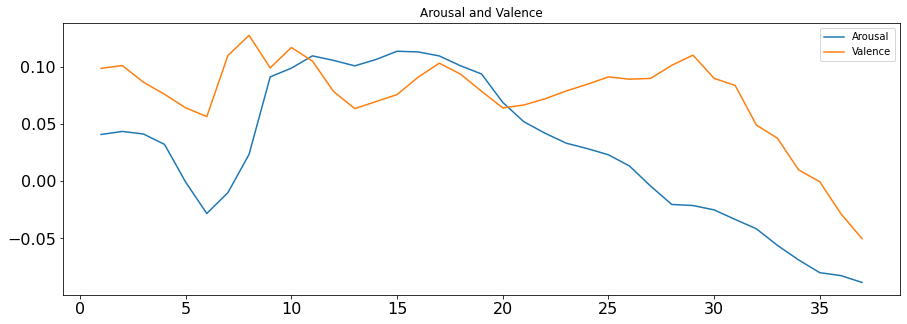

In [ ]:
avResults = pd.DataFrame({'Arousal': a_pred_test_list, 'Valence': v_pred_test_list})[0:-1]
avResults.loc[1:, ['Arousal', 'Valence']].plot(figsize=(15, 5), title='Arousal and Valence', fontsize=16)
plt.show()

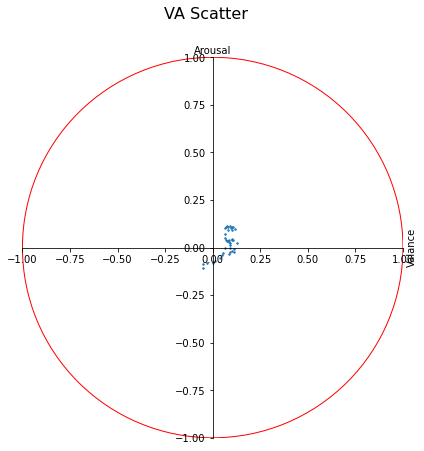

In [ ]:
fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

fig.suptitle('VA Scatter', fontsize=16)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
# Because we moved the label position so the x,y should be on other way round
ax.yaxis.set_label_position('right')
ax.xaxis.set_label_position('top')
plt.xlabel('Arousal')
plt.ylabel('Valance')
# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
unitCircle = plt.Circle((0, 0), 1, color='r', fill=False)
ax.add_patch(unitCircle)

plt.scatter(v_pred_test_list, a_pred_test_list, s=2)
plt.show()